In [1]:
from scipy.stats import dirichlet
from scipy.special import kl_div
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from tslearn.datasets import CachedDatasets, UCR_UEA_datasets

import os

In [2]:
# データセット可視化メソッド
def plot_data(X_train, y_train, name):
    plt.figure(figsize=(12,5))

    # true
    # plt.subplot(1, 2, 1)
    label = np.unique(y_train)
    # カラーマップを定義
    cmap = plt.get_cmap('tab10')  # タブルランカラーマップを使用
    colors = [cmap(i) for i in range(len(label))]

    for class_label in label:
        class_data = X_train[y_train == class_label][:,:,0].T
        plt.plot(class_data, label=f'_Class {class_label}', color=colors[class_label - 1], alpha=0.4)
        plt.plot([], label=f'Class {class_label}', color=colors[class_label - 1], alpha=0.3)

    plt.legend()
    # plt.text(0.05,0.95,'pred', transform=plt.gca().transAxes)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'{name}')

    plt.tight_layout()
    plt.show()

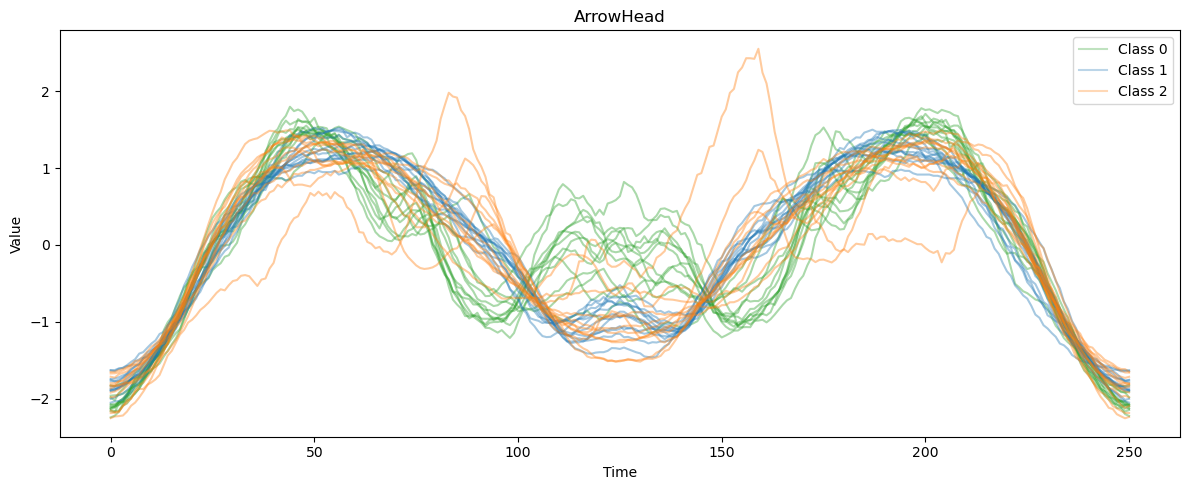

In [3]:
data_name = 'ArrowHead'

# データセットの読み込み（ここではUCR/UEAデータセットを使用）
X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset(data_name)

plot_data(X_train, y_train, data_name)

In [4]:
y_train

array([0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0,
       1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2])

trainデータの形状確認

In [45]:
X_train[:,:,0].shape

(36, 251)

trainデータ全体の頻度分布をからbinsの設定を取得

In [5]:
hist, bin_edges = np.histogram(X_train[:,:,0].T, bins='sturges', density=False)
print('hist:', hist,'\nbin_edges:', bin_edges)

bin_max = bin_edges.max()
bin_min = bin_edges.min()
bin_num = len(hist)

print('bin_max:', bin_max, '\nbin_min:', bin_min, '\nbin_num:', bin_num)

hist: [ 166  437  425  792  968  737  753  830  832  964 1328  732   59    6
    7] 
bin_edges: [-2.2570801  -1.93634127 -1.61560245 -1.29486362 -0.97412479 -0.65338597
 -0.33264714 -0.01190831  0.30883051  0.62956934  0.95030817  1.27104699
  1.59178582  1.91252465  2.23326347  2.5540023 ]
bin_max: 2.5540023 
bin_min: -2.2570801 
bin_num: 15


上記のbins設定でtraiｎデータ全体を頻度分布に変換

In [6]:
hist_li = []
for d in range(X_train.shape[0]):
    hist_ = np.histogram(X_train[d], bins=bin_num, range=(bin_min, bin_max), density=False)[0] + 0.000001
    hist_li.append(hist_ / hist_.sum()) # 合計を１にスケール

X_hist = np.array(hist_li)
X_hist

array([[1.59362580e-02, 6.37450201e-02, 3.18725120e-02, 2.39043850e-02,
        1.23505973e-01, 2.03187243e-01, 5.97609566e-02, 6.77290836e-02,
        8.76494011e-02, 9.96015917e-02, 7.56972106e-02, 1.47410354e-01,
        3.98406351e-09, 3.98406351e-09, 3.98406351e-09],
       [3.98406351e-09, 5.17928296e-02, 4.78087661e-02, 1.71314735e-01,
        5.97609566e-02, 6.37450201e-02, 5.97609566e-02, 9.56175282e-02,
        9.16334646e-02, 9.96015917e-02, 1.83266925e-01, 7.56972106e-02,
        3.98406351e-09, 3.98406351e-09, 3.98406351e-09],
       [3.98406351e-09, 6.37450201e-02, 3.58565755e-02, 1.15537846e-01,
        1.23505973e-01, 7.96812741e-02, 6.77290836e-02, 7.96812741e-02,
        7.56972106e-02, 1.03585655e-01, 1.35458163e-01, 1.19521909e-01,
        3.98406351e-09, 3.98406351e-09, 3.98406351e-09],
       [3.98406391e-02, 3.98406391e-02, 3.18725120e-02, 3.98406391e-02,
        1.27490036e-01, 8.76494011e-02, 1.15537846e-01, 1.31474100e-01,
        1.03585655e-01, 6.37450201e-0

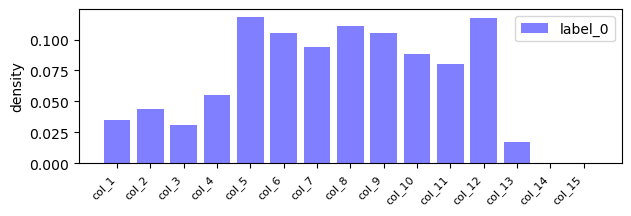

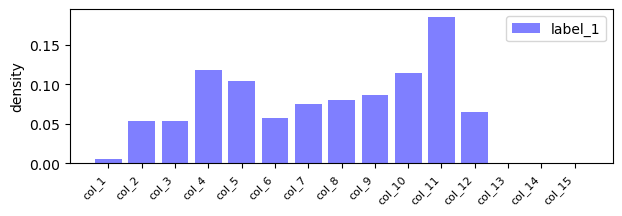

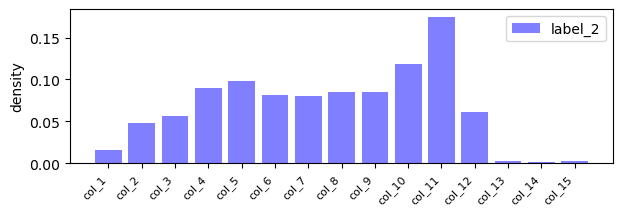

In [7]:
X_cols = [f'col_{i+1}' for i in range(X_hist.shape[1])]

for i in range(3):
    # ヒストグラムをプロット
    plt.figure(figsize=(7,2))
    plt.bar(X_cols, X_hist[y_train==i].mean(axis=0), color='blue', alpha=0.5, label=f'label_{i}')  # ヒストグラムを作成。binsはビンの数、alphaは透明度
    # plt.bar(X_cols, X_hist[y_train==1].mean(axis=0), color='red', alpha=0.5, label='label_1')
    # plt.bar(X_cols, X_hist[y_train==2].mean(axis=0), color='green', alpha=0.5, label='label_2')
    # plt.xlabel('')  # x軸ラベル
    plt.ylabel('density')  # y軸ラベル
    plt.title('')  # グラフタイトル
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.legend()
    plt.show()  # グラフを表示

In [8]:
# CPU Multi
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8'

import jax
print(jax.default_backend())
print(jax.devices("cpu"))

cpu
[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7)]


In [9]:
import pymc as pm
import arviz as az
print('version.', pm.__version__)
from pytensor import tensor as pt

version. 5.8.0


### 複数クラスに対するパラメータ推定

モデル定義

In [10]:
data_ = X_hist
data_

array([[1.59362580e-02, 6.37450201e-02, 3.18725120e-02, 2.39043850e-02,
        1.23505973e-01, 2.03187243e-01, 5.97609566e-02, 6.77290836e-02,
        8.76494011e-02, 9.96015917e-02, 7.56972106e-02, 1.47410354e-01,
        3.98406351e-09, 3.98406351e-09, 3.98406351e-09],
       [3.98406351e-09, 5.17928296e-02, 4.78087661e-02, 1.71314735e-01,
        5.97609566e-02, 6.37450201e-02, 5.97609566e-02, 9.56175282e-02,
        9.16334646e-02, 9.96015917e-02, 1.83266925e-01, 7.56972106e-02,
        3.98406351e-09, 3.98406351e-09, 3.98406351e-09],
       [3.98406351e-09, 6.37450201e-02, 3.58565755e-02, 1.15537846e-01,
        1.23505973e-01, 7.96812741e-02, 6.77290836e-02, 7.96812741e-02,
        7.56972106e-02, 1.03585655e-01, 1.35458163e-01, 1.19521909e-01,
        3.98406351e-09, 3.98406351e-09, 3.98406351e-09],
       [3.98406391e-02, 3.98406391e-02, 3.18725120e-02, 3.98406391e-02,
        1.27490036e-01, 8.76494011e-02, 1.15537846e-01, 1.31474100e-01,
        1.03585655e-01, 6.37450201e-0

In [11]:
data_.sum()

36.0

In [61]:
X_cols = [f'col_{i+1}' for i in range(data_.shape[1])]

K = 3

# モデルの定義
with pm.Model() as model_dirichlet:
    # coords(次元やインデックスを定義)
    model_dirichlet.add_coord('data', values=range(data_.shape[0]), mutable=True)
    model_dirichlet.add_coord('var', values=X_cols, mutable=True)
    model_dirichlet.add_coord('K', values=range(K), mutable=True)

    # 説明変数
    x = pm.MutableData('x', data_, dims=('data','var'))

    # 混合比の生成
    a = pm.Gamma('a', 2, 1)
    # a = pm.Uniform('a', lower=0.01, upper=100)
    w = pm.StickBreakingWeights('w', alpha=a, K=K-1, dims=('K',))
    label = pm.Categorical('label', p=w, dims=('data',))

    # 推論パラメータの事前分布
    alpha_ = pm.HalfNormal('alpha', dims=('K','var'), sigma=10)
    # Dirichlet分布
    result = pm.Dirichlet("obs", a=alpha_[label], observed=x, dims=('data','var'))


# 定義した各パラメータの情報
display(model_dirichlet.model)

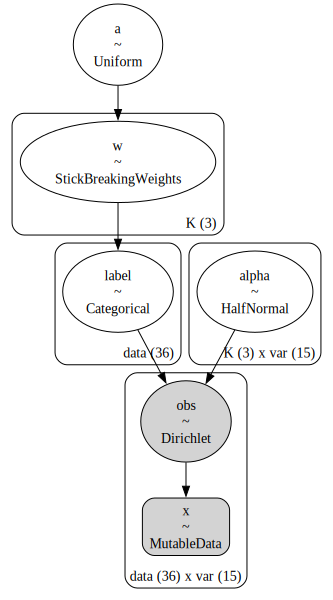

In [62]:
# 構造
modeldag = pm.model_to_graphviz(model_dirichlet)
display(modeldag)


In [63]:
model_dirichlet.debug()

point={'a_interval__': array(0.), 'w_simplex__': array([-1.29084056, -1.31064122]), 'label': array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]), 'alpha_log__': array([[2.30258509, 2.30258509, 2.30258509, 2.30258509, 2.30258509,
        2.30258509, 2.30258509, 2.30258509, 2.30258509, 2.30258509,
        2.30258509, 2.30258509, 2.30258509, 2.30258509, 2.30258509],
       [2.30258509, 2.30258509, 2.30258509, 2.30258509, 2.30258509,
        2.30258509, 2.30258509, 2.30258509, 2.30258509, 2.30258509,
        2.30258509, 2.30258509, 2.30258509, 2.30258509, 2.30258509],
       [2.30258509, 2.30258509, 2.30258509, 2.30258509, 2.30258509,
        2.30258509, 2.30258509, 2.30258509, 2.30258509, 2.30258509,
        2.30258509, 2.30258509, 2.30258509, 2.30258509, 2.30258509]])}

No problems found


In [64]:
%%time
# MCMC実行
# バックエンドでNumPyroで実行
with model_dirichlet:
    # MCMCによる推論
    trace = pm.sample(draws=3000, tune=1000, chains=1, #nuts_sampler="numpyro", 
                        random_seed=1, return_inferencedata=True,)
# >> Wall time: 45.5 s
# データの保存 to_netcdfの利用
# trace.to_netcdf('model_random1.nc')
# データの読み込み from_netcdfの利用
#trace = az.from_netcdf('model_random1.nc')

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [a, w, alpha]
>CategoricalGibbsMetropolis: [label]


Sampling 1 chain for 1_000 tune and 3_000 draw iterations (1_000 + 3_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


CPU times: user 16 s, sys: 228 ms, total: 16.2 s
Wall time: 16.3 s


numpyroをサンプラーで指定したら、モデルが連続的でないためエラーが出た

In [65]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

Max rhat: nan


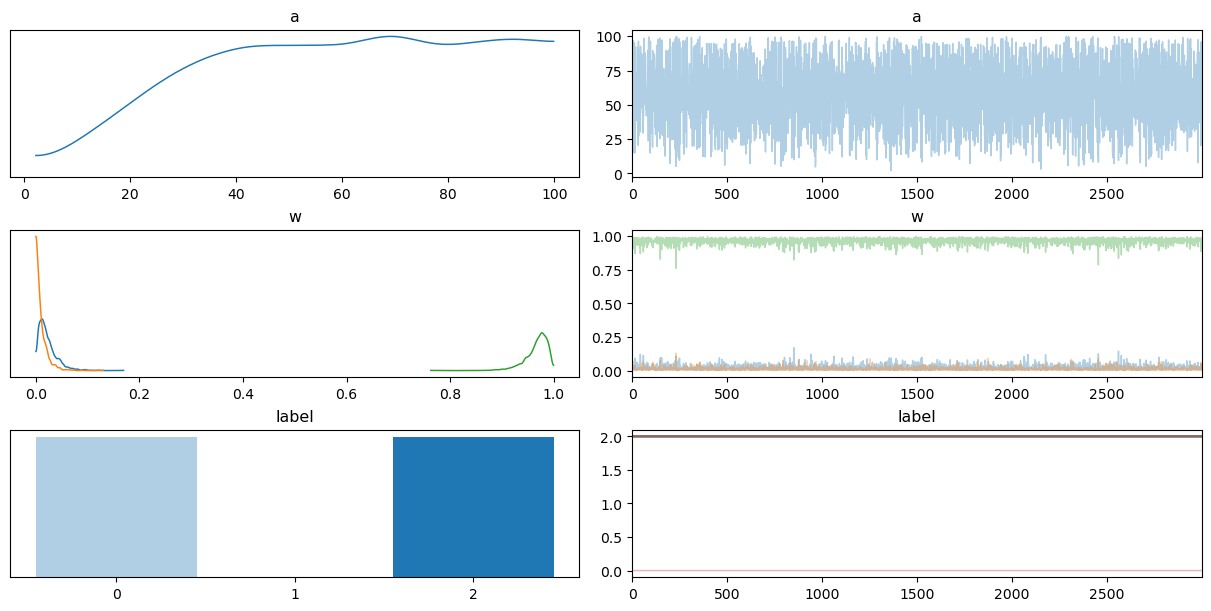

/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (45) in plot_posterior, generating only 40 plots
  warnings.warn(


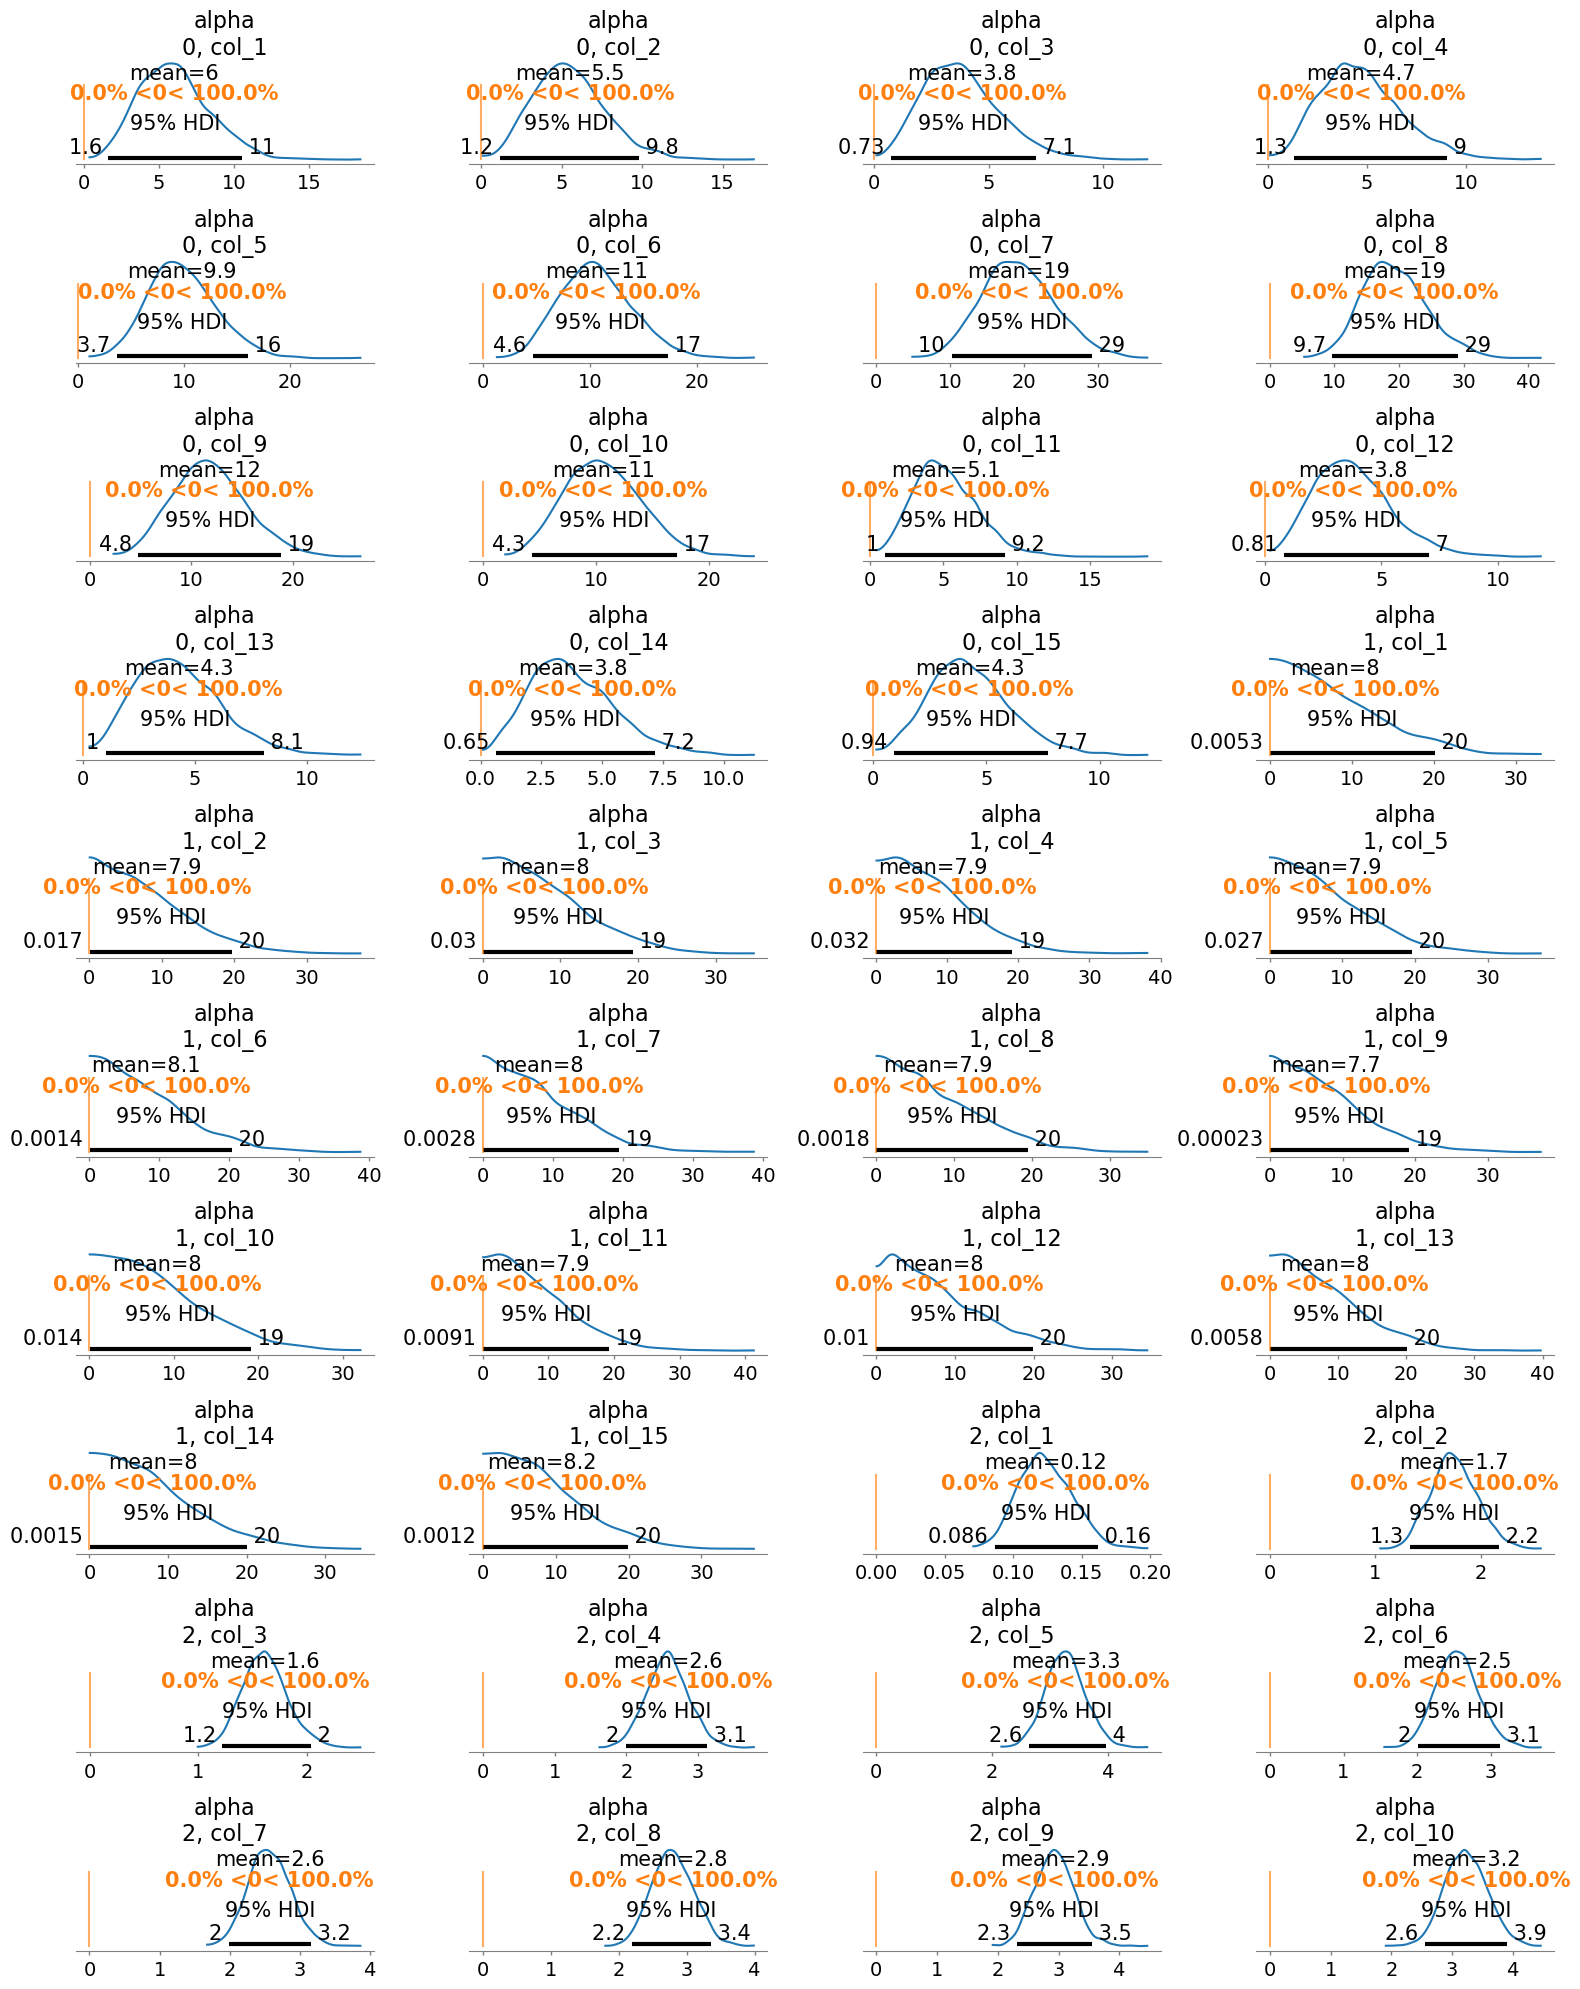

In [66]:
# MCMCの収束を評価
rhat_vals = az.rhat(trace).values()
# 最大のRhatを確認
result = np.max([np.max(i.values) for i in rhat_vals if i.name in ['w']])
print('Max rhat:', result)
# 1.1以上のRhatを確認
for i in rhat_vals:
    if np.max(i.values)>=1.1:
        print(i.name, np.max(i.values), np.mean(i.values), i.values.shape, sep='  ====>  ')


# トレースプロットとか
# plot_trace
az.plot_trace(trace, backend_kwargs={"constrained_layout":True}, var_names=['a','w','label'])
plt.show()

# # forest plotでRハットと一緒に可視化
# az.plot_forest(trace, combined=True, hdi_prob=0.95, r_hat=True, var_names=["coef", "intercept", "random", 'mu'])
# plt.tight_layout()
# plt.show()

# 事後分布の確認
az.plot_posterior(trace, hdi_prob=0.95, var_names=['alpha'], ref_val=0, figsize=(16,20))
plt.tight_layout()
plt.show()

# # Energy Plot
# az.plot_energy(trace)
# plt.show()


サンプリングされたラベルデータを観察

In [67]:
trace.posterior.label[0].shape

(3000, 36)

In [68]:
np.unique(trace.posterior.label[0], return_counts=True)

(array([0, 2]), array([  3000, 105000]))

In [69]:
np.unique(trace.posterior.label[0,:,10], return_counts=True)

(array([2]), array([3000]))

In [30]:
re_li = []

for i in range(len(X_hist)):
    v_, c_ = np.unique(trace.posterior.label[0,:,i], return_counts=True)
    dic_ = {}
    if (0 in v_)&(1 in v_):
        dic_['0']=c_[0]
        dic_['1']=c_[1]
    elif (0 in v_)&(1 not in v_):
        dic_['0']=c_[0]
        dic_['1']=0
    elif (0 not in v_)&(1 in v_):
        dic_['0']=0
        dic_['1']=c_[0]

    re_li.append(dic_)



In [31]:
pd.DataFrame(re_li)

,0,1
0,0,3000
1,0,3000
2,0,3000
3,0,3000
4,0,3000
5,0,3000
6,0,3000
7,0,3000
8,0,3000
9,0,3000


3クラス用意しても、#23しか検出されない

SBPの検出をよくするには何を調節すれば良いのだろうか？？？

### 以下未使用

label_0と、全体の頻度分布を比較

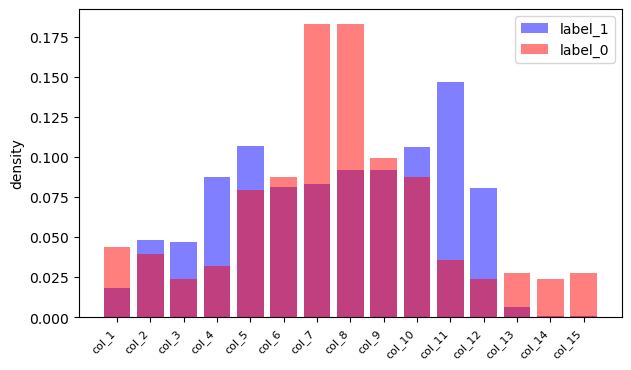

In [115]:
X_cols = [f'col_{i+1}' for i in range(X_hist.shape[1])]

# ヒストグラムをプロット
plt.figure(figsize=(7,4))
plt.bar(X_cols, X_hist.mean(axis=0), color='blue', alpha=0.5, label='label_1')  # ヒストグラムを作成。binsはビンの数、alphaは透明度
plt.bar(X_cols, X_hist[23], color='red', alpha=0.5, label='label_0')
# plt.xlabel('')  # x軸ラベル
plt.ylabel('density')  # y軸ラベル
plt.title('')  # グラフタイトル
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.legend()
plt.show()  # グラフを表示

パラメータalphaのサンプリングを確認

In [118]:
trace.posterior.alpha.shape

(1, 3000, 2, 15)

In [126]:
trace.posterior.alpha[0,:,0,:]

<xarray.DataArray 'alpha' (draw: 3000, var: 15)>
array([[3.13992497, 2.26901061, 2.26555449, ..., 4.52119707, 2.43443278,
        3.87310033],
       [7.21625273, 4.01264739, 6.19416342, ..., 3.75477864, 5.62996852,
        4.33755522],
       [4.17778061, 7.90727654, 1.62084426, ..., 5.39912296, 2.7850165 ,
        2.42602152],
       ...,
       [4.42161235, 4.28440601, 1.49715756, ..., 2.27495879, 1.67750234,
        5.05654304],
       [5.4417726 , 5.86628206, 3.36917289, ..., 5.33664853, 2.6405355 ,
        5.663411  ],
       [9.21763237, 4.62865263, 3.33455201, ..., 4.8690752 , 6.10519789,
        3.64049177]])
Coordinates:
    chain    int64 0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 2993 2994 2995 2996 2997 2998 2999
    K        int64 0
  * var      (var) <U6 'col_1' 'col_2' 'col_3' ... 'col_13' 'col_14' 'col_15'

In [127]:
# 各パラメータの事後分布の確認・評価（統計量）
df_summary = pm.summary(trace)
# df_summary['alpha_normal'] = df_summary['mean'] / df_summary['mean'].sum()
# df_summary['alpha_normal']
df_summary

arviz - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
label[0],1.000,0.000,1.000,1.000,0.000,0.000,3000.0,3000.0,NaN
label[1],1.000,0.000,1.000,1.000,0.000,0.000,3000.0,3000.0,NaN
label[2],1.000,0.000,1.000,1.000,0.000,0.000,3000.0,3000.0,NaN
label[3],1.000,0.000,1.000,1.000,0.000,0.000,3000.0,3000.0,NaN
label[4],1.000,0.000,1.000,1.000,0.000,0.000,3000.0,3000.0,NaN
...,...,...,...,...,...,...,...,...,...
"alpha[1, col_11]",4.134,0.414,3.299,4.866,0.009,0.006,2323.0,2020.0,NaN
"alpha[1, col_12]",0.365,0.056,0.261,0.472,0.001,0.001,3381.0,1933.0,NaN
"alpha[1, col_13]",0.082,0.014,0.056,0.107,0.000,0.000,6108.0,2182.0,NaN
"alpha[1, col_14]",0.066,0.011,0.047,0.086,0.000,0.000,5042.0,2193.0,NaN


In [134]:
df_a0 = df_summary.loc[[ind for ind in df_summary.index if 'alpha[0,' in ind]]
df_a0['alpha_normal'] = df_a0['mean'] / df_a0['mean'].sum()
print(df_a0['alpha_normal'].sum())

df_a1 = df_summary.loc[[ind for ind in df_summary.index if 'alpha[1,' in ind]]
df_a1['alpha_normal'] = df_a1['mean'] / df_a1['mean'].sum()
print(df_a1['alpha_normal'].sum())

0.9999999999999999
1.0


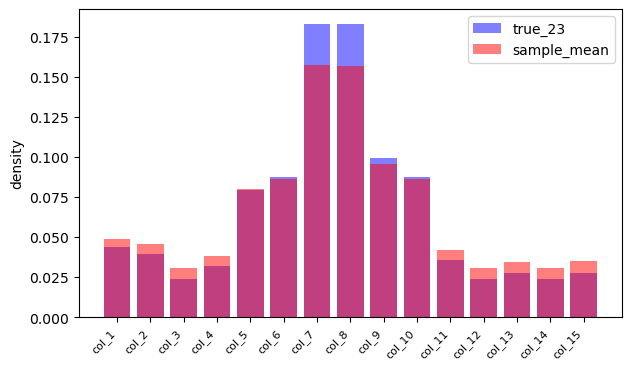

In [137]:
# ヒストグラムをプロット
plt.figure(figsize=(7,4))
plt.bar(X_cols, data_[23], color='blue', alpha=0.5, label='true_23')  # ヒストグラムを作成。binsはビンの数、alphaは透明度
plt.bar(X_cols, df_a0['alpha_normal'].values, color='red', alpha=0.5, label='sample_mean')
# plt.xlabel('')  # x軸ラベル
plt.ylabel('density')  # y軸ラベル
plt.title('')  # グラフタイトル
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.legend()
plt.show()  # グラフを表示

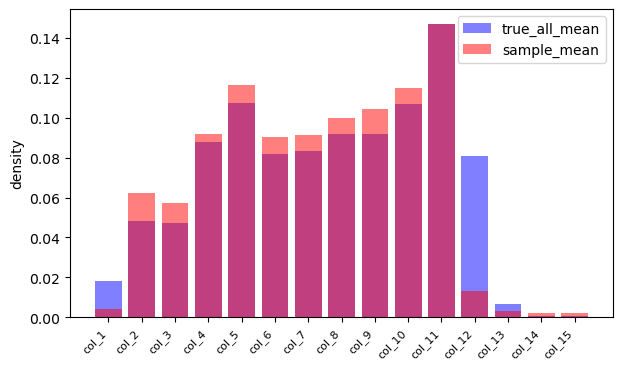

In [136]:
# ヒストグラムをプロット
plt.figure(figsize=(7,4))
plt.bar(X_cols, data_.mean(axis=0), color='blue', alpha=0.5, label='true_all_mean')  # ヒストグラムを作成。binsはビンの数、alphaは透明度
plt.bar(X_cols, df_a1['alpha_normal'].values, color='red', alpha=0.5, label='sample_mean')
# plt.xlabel('')  # x軸ラベル
plt.ylabel('density')  # y軸ラベル
plt.title('')  # グラフタイトル
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.legend()
plt.show()  # グラフを表示